In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST); path, path.ls()

(Path('/home/jovyan/.fastai/data/mnist_png'),
 (#2) [Path('/home/jovyan/.fastai/data/mnist_png/testing'),Path('/home/jovyan/.fastai/data/mnist_png/training')])

In [ ]:
items = get_image_files(path)
items[:10]

(#10) [Path('/home/jovyan/.fastai/data/mnist_png/testing/7/4199.png'),Path('/home/jovyan/.fastai/data/mnist_png/testing/7/6662.png'),Path('/home/jovyan/.fastai/data/mnist_png/testing/7/7320.png'),Path('/home/jovyan/.fastai/data/mnist_png/testing/7/5914.png'),Path('/home/jovyan/.fastai/data/mnist_png/testing/7/5422.png'),Path('/home/jovyan/.fastai/data/mnist_png/testing/7/7544.png'),Path('/home/jovyan/.fastai/data/mnist_png/testing/7/3743.png'),Path('/home/jovyan/.fastai/data/mnist_png/testing/7/383.png'),Path('/home/jovyan/.fastai/data/mnist_png/testing/7/9015.png'),Path('/home/jovyan/.fastai/data/mnist_png/testing/7/2565.png')]

In [ ]:
im = PILImageBW.create(items[0])

<AxesSubplot: >

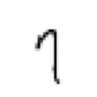

In [ ]:
im.show()

In [ ]:
splitter = GrandparentSplitter(
    train_name="training",
    valid_name="testing",
)

In [ ]:
splits = splitter(items)
splits[0][:5], splits[1][:5]

([10000, 10001, 10002, 10003, 10004], [0, 1, 2, 3, 4])

In [ ]:
len(splits[0]), len(splits[1])

(60000, 10000)

In [ ]:
dsrc = Datasets(
    items,
    tfms=[[PILImageBW.create], [parent_label, Categorize]],
    splits=splits
)

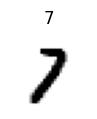

In [ ]:
show_at(dsrc.train, 3);

In [ ]:
item_tfms = [CropPad(34), RandomCrop(size=28), ToTensor()]

In [ ]:
batch_tfms = [IntToFloatTensor(), Normalize()]

In [ ]:
dls = dsrc.dataloaders(
    bs=128,
    after_item=item_tfms,
    after_batch=batch_tfms
)

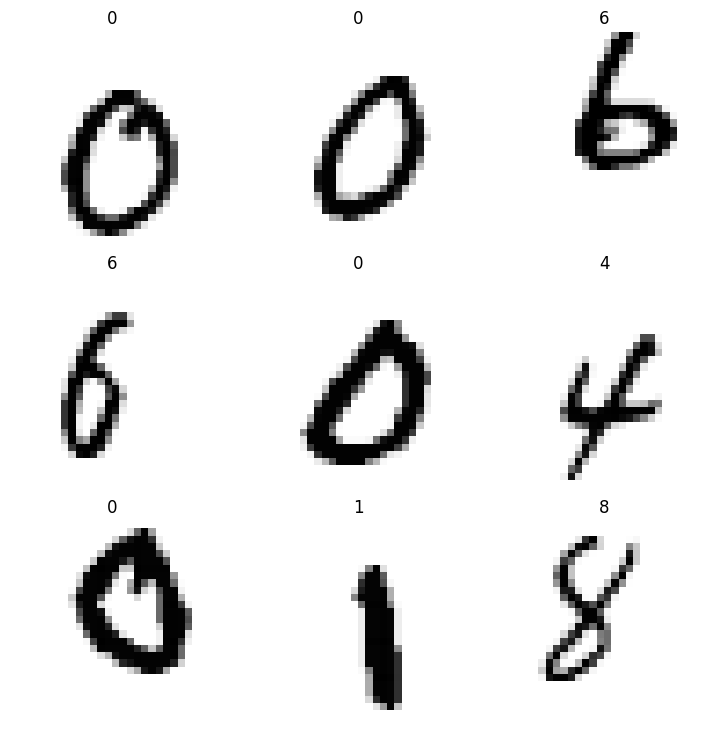

In [ ]:
dls.show_batch()

In [ ]:
xb, yb = dls.one_batch()

In [ ]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
dls.c

10

In [ ]:
model = resnet18( num_classes=dls.c).cuda(); model.fc

Linear(in_features=512, out_features=10, bias=True)

In [ ]:
model(xb)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[128, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [ ]:
model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
model.conv1 = nn.Conv2d(
    in_channels=1, 
    out_channels=64, 
    kernel_size=(7,7), 
    stride=(2,2), 
    padding=(3,3), 
    bias=False
)

In [ ]:
model.cuda();

In [ ]:
model(xb)

TensorImageBW([[ 0.8653, -0.5842, -0.0095,  ..., -0.4335, -0.5770, -0.3396],
               [ 1.0708, -0.5977, -0.6581,  ...,  0.8838, -0.1800,  0.0831],
               [ 0.8686,  0.7356,  0.1484,  ..., -0.7021,  0.5971, -0.2051],
               ...,
               [ 0.4341, -0.5231, -0.3952,  ..., -0.4436, -0.9311,  0.6171],
               [ 0.0964,  0.0140, -1.6474,  ..., -0.5224, -1.1066,  0.5010],
               [-0.0789,  0.3279, -0.2987,  ..., -0.3033, -0.7143, -0.5016]],
              device='cuda:0', grad_fn=<AliasBackward0>)

In [ ]:
learn = Learner(dls, model, metrics=[accuracy])

In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.122788,0.153307,0.953300,00:09


In [ ]:
items[0]

Path('/home/jovyan/.fastai/data/mnist_png/testing/7/4199.png')

In [ ]:
preds = learn.predict(items[0]); preds

('7',
 tensor(7),
 tensor([6.1501e-04, 7.0428e-02, 3.8973e-03, 2.9338e-03, 3.8078e-03, 1.0854e-03,
         3.5933e-05, 8.9145e-01, 4.3205e-03, 2.1431e-02]))

In [ ]:
dl = learn.dls.test_dl(items[:1])
inps, preds, _, decoded_preds = learn.get_preds(dl=dl, with_decoded=True, with_input=True)
image, class_prediction = learn.dls.decode_batch((inps,) + tuplify(decoded_preds))[0]

In [ ]:
class_prediction, decoded_preds

('7', tensor([7]))

In [ ]:
learn.dls.after_item, learn.dls.after_batch

(Pipeline: CropPad -- {'size': (34, 34), 'pad_mode': 'zeros'} -> RandomCrop -- {'size': (28, 28), 'p': 1.0} -> ToTensor,
 Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': None, 'std': None, 'axes': (0, 2, 3)})

In [ ]:
learn.dls.after_batch[1].mean, learn.dls.after_batch[1].std

(TensorImageBW([[[[0.1302]]]], device='cuda:0'),
 TensorImageBW([[[[0.3081]]]], device='cuda:0'))

In [ ]:
type_tfms = Pipeline([PILImageBW.create])
item_tfms = Pipeline([CropPad((34,34)), CropPad((28,28)), ToTensor()])
batch_tfms = Pipeline([
    IntToFloatTensor(), 
    Normalize.from_stats([[[[0.1302]]]], [[[[0.3081]]]])
])

In [ ]:
items[0]

Path('/home/jovyan/.fastai/data/mnist_png/testing/7/4199.png')

In [ ]:
im = type_tfms(items[0]); im.shape

(28, 28)

In [ ]:
item_tfms(im).shape

torch.Size([1, 28, 28])

In [ ]:
batch_tfms(item_tfms(im).cuda()).shape

torch.Size([1, 1, 28, 28])

In [ ]:
net = learn.model
net.eval()
t_im = batch_tfms(item_tfms(im).cuda())

In [ ]:
with torch.no_grad():
    out = net(t_im)

In [ ]:
out.argmax(dim=-1)

TensorImageBW([7], device='cuda:0')

In [ ]:
out.softmax(-1)

TensorImageBW([[6.1411e-04, 7.0375e-02, 3.8911e-03, 2.9296e-03, 3.8029e-03,
                1.0836e-03, 3.5855e-05, 8.9155e-01, 4.3128e-03, 2.1403e-02]],
              device='cuda:0')